# Portfolio 5

## What is in the scope?
* 600k entries, nine columns including ID (remove ID or maybe find a trend for each user?); tenth being fraud or not.
* Predicting new payments; train test split.
* Detecting Fraud, classification.
* Care about FP as well as TP; 
    * Confusion Matrix
    * don't want real transactions flagged as fraud. (FP: Type 1)
    * don't want fraudulent transactions getting through (FN: Type 2) 
* Try multiple classification models. SEMMA

## Feature Definitions
* Step: Time in simulation
* Customer: Unique ID
* zipCodeOrigin: The zip code of origin.
* Merchant: Merchant's unique ID
* zipMerchant: Merchant's zip code
* Age: Age categories
* Gender: Customers gender
* Category: Types of payments/industires; leisure, transportation, food, fashio0n. etc.
* Amount: Transaction amount
* Fraud: Target variable, 0 being non fraudulent, 1 being fraudulent

In [73]:
%matplotlib inline

# Core & ML
import numpy  as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__)) #had to update sklearn, dependency on something in 23.1

#Classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Class Imbalance
from imblearn.over_sampling import SMOTE #conda install -c conda-forge imbalanced-learn
from collections import Counter

#Support Vector Machine
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#KNN
from sklearn.neighbors import KNeighborsClassifier

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#MLP
from sklearn.neural_network import MLPClassifier

#Perceptron
from sklearn.linear_model import Perceptron

# Visualization
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # Pyplot is such a general function that it deserves its own alias
import seaborn as sns

#removes scientific notation
np.set_printoptions(suppress=True) 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

The scikit-learn version is 0.24.0.


In [2]:
df = pd.read_csv('bs140513_032310.csv')#https://www.kaggle.com/ntnu-testimon/banksim1/discussion/52254
features = list(df.columns)
target = features.pop()
features = features[:-1]
df.shape

(594643, 10)

In [3]:
df.isnull().any() #No Null

step           False
customer       False
age            False
gender         False
zipcodeOri     False
merchant       False
zipMerchant    False
category       False
amount         False
fraud          False
dtype: bool

# Sample, Explore & Modification

In [4]:
print(features)
print(target)

['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category']
fraud


In [5]:
df[target].value_counts() # 7200 / 594643 === 1.2% fraud, class imbalance?

0    587443
1      7200
Name: fraud, dtype: int64

In [6]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [7]:
df.info() #check datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


## Object type data is contained in ' ', need to filter these to apply datatype conversion

In [8]:
df['customer'] = df['customer'].map(lambda x: x.replace("'", ""))
df['age'] = df['age'].map(lambda x: x.replace("'", ""))
df['gender'] = df['gender'].map(lambda x: x.replace("'", ""))
df['zipcodeOri'] = df['zipcodeOri'].map(lambda x: x.replace("'", ""))
df['merchant'] = df['merchant'].map(lambda x: x.replace("'", ""))
df['zipMerchant'] = df['zipMerchant'].map(lambda x: x.replace("'", ""))
df['category'] = df['category'].map(lambda x: x.replace("'", ""))

In [9]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


## Completely Useless Features

In [10]:
df.zipcodeOri.unique()

array(['28007'], dtype=object)

In [11]:
df.zipMerchant.unique()

array(['28007'], dtype=object)

In [12]:
df = df.drop(['zipMerchant', 'zipcodeOri'], 1)

## Unkown in categories, sensitive data expected. How to handle?

### Gender

In [13]:
df.gender.unique() #Unknown?

array(['M', 'F', 'E', 'U'], dtype=object)

In [14]:
df['gender'].value_counts() # 515/594643

F    324565
M    268385
E      1178
U       515
Name: gender, dtype: int64

In [15]:
print("Find most common fraud gender groups: ",df.groupby('gender')['fraud'].value_counts()) 
# U here doesn't matter anyway. No FRAUD (1) values

Find most common fraud gender groups:  gender  fraud
E       0          1171
        1             7
F       0        319807
        1          4758
M       0        265950
        1          2435
U       0           515
Name: fraud, dtype: int64


### Age

In [16]:
df.age.unique() #Unknown?

array(['4', '2', '3', '5', '1', '6', 'U', '0'], dtype=object)

In [17]:
df['age'].value_counts()

2    187310
3    147131
4    109025
5     62642
1     58131
6     26774
0      2452
U      1178
Name: age, dtype: int64

In [18]:
print("Find most common fraud age groups: ",df.groupby('age')['fraud'].value_counts()) 
#Only 7 counts of fraud in unknown. 7/7200 isn't all that meaningful so I could just remove, 7200/600k tho? Class imbalance?

Find most common fraud age groups:  age  fraud
0    0          2404
     1            48
1    0         57442
     1           689
2    0        184966
     1          2344
3    0        145376
     1          1755
4    0        107615
     1          1410
5    0         61956
     1           686
6    0         26513
     1           261
U    0          1171
     1             7
Name: fraud, dtype: int64


## Where is fraud most common?

In [19]:
print("Find most common fraud categories: ",df.groupby('category')['amount','fraud'].mean())

Find most common fraud categories:                         amount  fraud
category                            
es_barsandrestaurants   43.46   0.02
es_contents             44.55   0.00
es_fashion              65.67   0.02
es_food                 37.07   0.00
es_health              135.62   0.11
es_home                165.67   0.15
es_hotelservices       205.61   0.31
es_hyper                45.97   0.05
es_leisure             288.91   0.95
es_otherservices       135.88   0.25
es_sportsandtoys       215.72   0.50
es_tech                120.95   0.07
es_transportation       26.96   0.00
es_travel             2250.41   0.79
es_wellnessandbeauty    65.51   0.05


Most likely in leisure and travel

## Removing Unknowns

In [20]:
df.shape

(594643, 8)

In [21]:
# Remove Age Unknown, Fraud == True (7 important Values for target, 1178 total)
# Remove Gender Unknown, Fraud == False (515 Values total, non important to target)
# 1600 total
df = df[df.age != 'U']
df = df[df.gender != 'U']

In [22]:
df.shape

(592950, 8)

## Changing Data Types?

https://stackoverflow.com/questions/28034424/pandas-scatter-matrix-plot-categorical-variables

Need to change data types for visualization

In [23]:
df['gen_int'] = np.nan
df.loc[df['gender'] == 'M', 'gen_int'] = 0 #Male
df.loc[df['gender'] == 'F', 'gen_int'] = 1 #Female
df.loc[df['gender'] == 'E', 'gen_int'] = 2 #Enterprise
df = df.drop('gender', 1)
df['age'] = df['age'].astype(np.int64)
df

,step,customer,age,merchant,category,amount,fraud,gen_int
0,0,C1093826151,4,M348934600,es_transportation,4.55,0,0.00
1,0,C352968107,2,M348934600,es_transportation,39.68,0,0.00
2,0,C2054744914,4,M1823072687,es_transportation,26.89,0,1.00
3,0,C1760612790,3,M348934600,es_transportation,17.25,0,0.00
4,0,C757503768,5,M348934600,es_transportation,35.72,0,0.00
...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,M1823072687,es_transportation,20.53,0,1.00
594639,179,C650108285,4,M1823072687,es_transportation,50.73,0,1.00
594640,179,C123623130,2,M349281107,es_fashion,22.44,0,1.00
594641,179,C1499363341,5,M1823072687,es_transportation,14.46,0,0.00


In [24]:
print("Customer Unique Count: ",df.customer.nunique())
print("Category Unique Count: ",df.category.nunique())
print("Merchant Unique Count: ",df.merchant.nunique())#Enumerate?

Customer Unique Count:  4100
Category Unique Count:  15
Merchant Unique Count:  50


In [25]:
#Convert to category so I can use the cat codes to enumerate quickly
df['category'] = df['category'].astype('category')
df['customer'] = df['customer'].astype('category')
df['merchant'] = df['merchant'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592950 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   step      592950 non-null  int64   
 1   customer  592950 non-null  category
 2   age       592950 non-null  int64   
 3   merchant  592950 non-null  category
 4   category  592950 non-null  category
 5   amount    592950 non-null  float64 
 6   fraud     592950 non-null  int64   
 7   gen_int   592950 non-null  float64 
dtypes: category(3), float64(2), int64(3)
memory usage: 29.6 MB


In [26]:
df['category'] = df['category'].cat.codes
df['customer'] = df['customer'].cat.codes
df['merchant'] = df['merchant'].cat.codes

In [27]:
df.head()

,step,customer,age,merchant,category,amount,fraud,gen_int
0,0,210,4,30,12,4.55,0,0.00
1,0,2746,2,30,12,39.68,0,0.00
2,0,2280,4,18,12,26.89,0,1.00
3,0,1646,3,30,12,17.25,0,0.00
4,0,3578,5,30,12,35.72,0,0.00


## Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000188001809C8>,
      dtype=object)

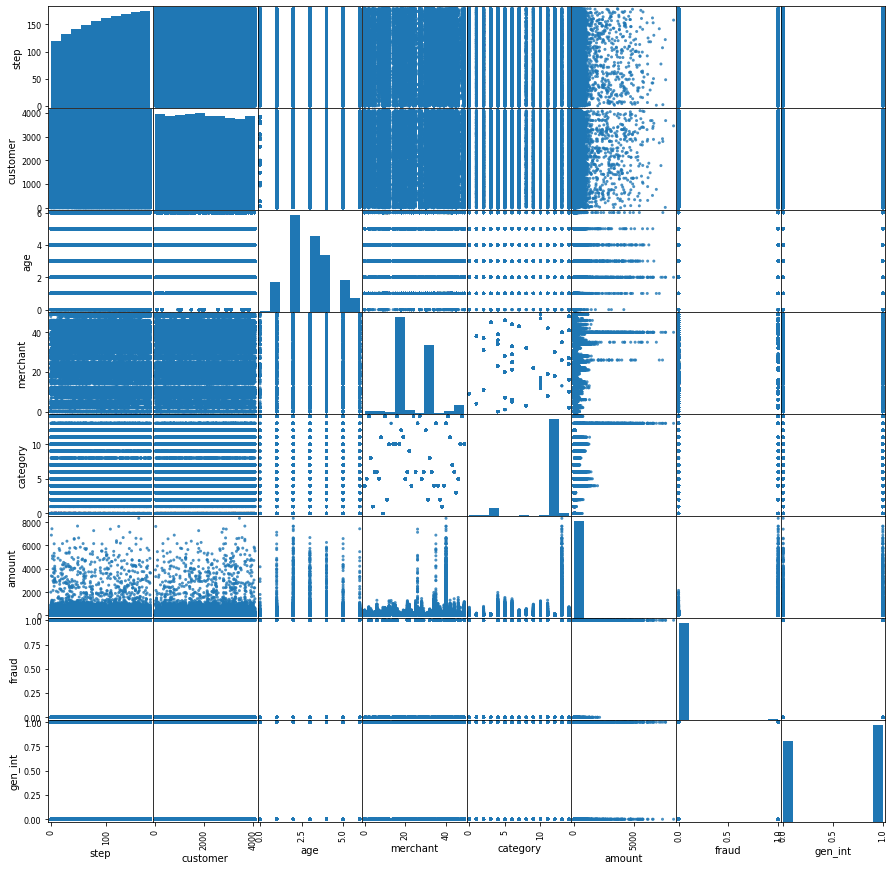

In [28]:
pd.plotting.scatter_matrix(df, alpha = 0.8, figsize=(15,15))

In [29]:
df.corr(method='pearson')

,step,customer,age,merchant,category,amount,fraud,gen_int
step,1.00,0.01,0.00,-0.16,-0.02,-0.01,-0.01,0.00
customer,0.01,1.00,0.00,0.01,0.00,0.01,0.01,0.01
age,0.00,0.00,1.00,0.01,0.01,-0.00,-0.00,-0.02
merchant,-0.16,0.01,0.01,1.00,-0.25,0.07,0.10,0.01
category,-0.02,0.00,0.01,-0.25,1.00,-0.10,-0.11,-0.01
amount,-0.01,0.01,-0.00,0.07,-0.10,1.00,0.49,0.01
fraud,-0.01,0.01,-0.00,0.10,-0.11,0.49,1.00,0.03
gen_int,0.00,0.01,-0.02,0.01,-0.01,0.01,0.03,1.00


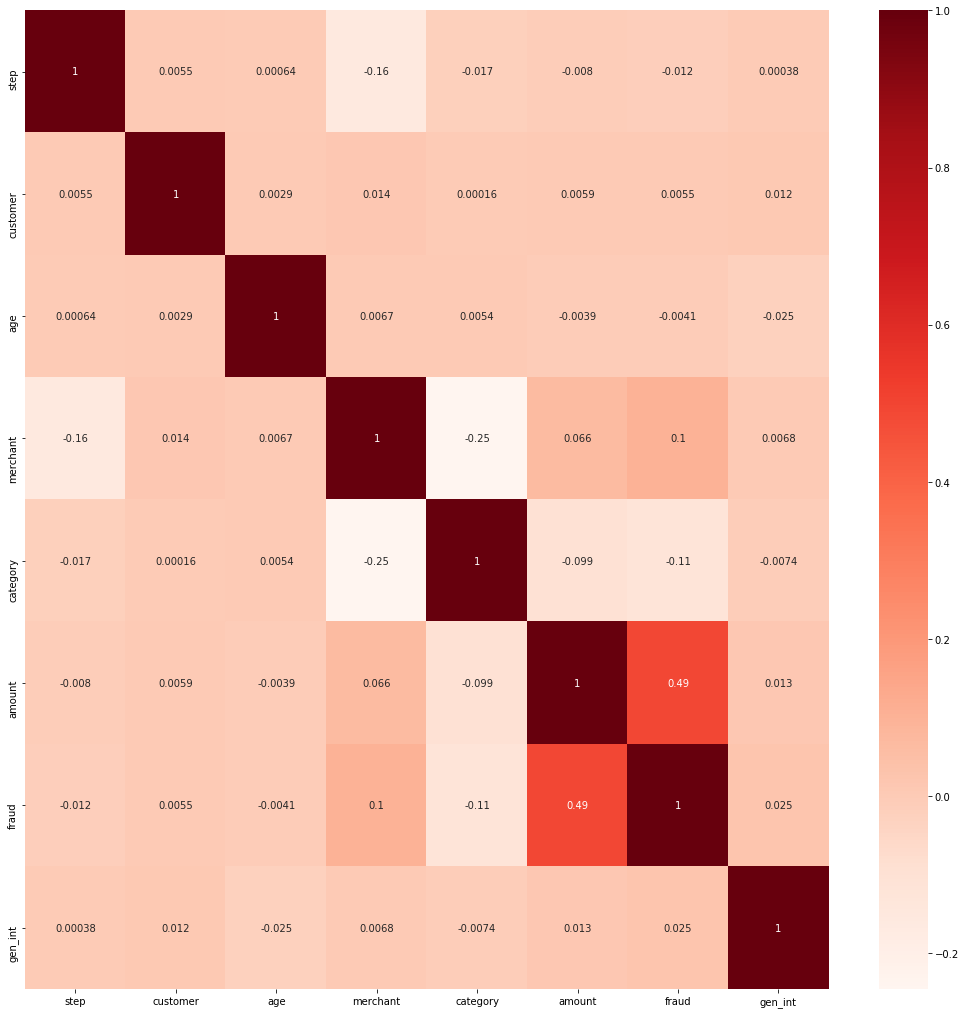

In [30]:
# More Visualization
cor = df.corr()
plt.figure(figsize=(18,18))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [31]:
# [Amount] clearly has impact on fraud (high amount is suspsicious)
# is step useless for a model overall? Or can I make new features to track an individuals average spending over X period?
# Anything 3+ SD from this average spending is sus?
# Is there a latent variable?
# Merchant has some correlation with fraud? Do fraudsters typically buy from the same merchant with the same amount, lets see.

In [32]:
cor_merchant = abs(cor["merchant"])
#Selecting highly correlated features
relevant_features = cor_merchant[cor_merchant>0.3]
relevant_features 
#Nope to that hypothesis

merchant   1.00
Name: merchant, dtype: float64

In [33]:
cor_amount = abs(cor["amount"])
#Selecting highly correlated features
relevant_features = cor_amount[cor_amount>0.3]
relevant_features 
#Amount doesn't correlate with anything else, so its a safe variable on its own.
#Could be used in a new variable though perhaps, amount explaining category?

amount   1.00
fraud    0.49
Name: amount, dtype: float64

In [34]:
df.drop('step', 1) #no meaningful correlation with target or other features (useless for latent and target)

,customer,age,merchant,category,amount,fraud,gen_int
0,210,4,30,12,4.55,0,0.00
1,2746,2,30,12,39.68,0,0.00
2,2280,4,18,12,26.89,0,1.00
3,1646,3,30,12,17.25,0,0.00
4,3578,5,30,12,35.72,0,0.00
...,...,...,...,...,...,...,...
594638,1635,3,18,12,20.53,0,1.00
594639,3362,4,18,12,50.73,0,1.00
594640,526,2,31,2,22.44,0,1.00
594641,1079,5,18,12,14.46,0,0.00


### Updating List Var:

In [35]:
features.remove('zipMerchant')
features.remove('zipcodeOri')
features.remove('gender')
features.remove('step')
features.append('amount')
features.append('gen_int')

## Dealing With Class Imbalance
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
* About  1% of the data is fraudulent, need someway to balance the data to avoid awkward data splits in training and testing. 
* Class imbalance equals faulty accuracy scores etc. due to weighting heavily on TN

### Ideas
* SMOTE :creating fakes using k-nearest (looks pretty intuitive/easy) [Oversampling]
* (Class weight) hyper-params
* Resampling (removing from majority, and/or adding to minority)
    
### The following dry run was completed before balancing the classes with smote.
* NB:Perceptron in row [5] had the wrong confusion matrix data, please ignore this entry.
* MLP has slight advantage over Linear SVC, and SVC with a linear Kernel with better F1 scores.
    * SVC Has a noticably longer runtime though.

<img src="original.png">

## Smote

In [36]:
features
X = df[features]
y = df[target]

In [37]:
smote = SMOTE(sampling_strategy='minority') #resamples minority
X_balanced, y_balanced = smote.fit_sample(X, y)

In [38]:
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_balanced))

Original dataset shape Counter({0: 585757, 1: 7193})
Resampled dataset shape Counter({0: 585757, 1: 585757})


# Model & Assess

In [39]:
model_track = pd.DataFrame(columns=['Type', 'ID','TP', 'TN', 'FP', 'FN',  "Accuracy", "Precision", "Recall", "F1_score"])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [41]:
# Method to append models classification report into a DF:
def save_models(m_type, m_ID, model_track):
    model_track_update = model_track.append({
        "Type":  m_type,
        "ID": m_ID,
        "TP": tp, 
        "TN": tn,
        "FP": fp, 
        "FN": fn,
        "Accuracy": accuracy_score(y_test, y_pred), 
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred), 
        "F1_score": f1_score(y_test, y_pred), 
    }, ignore_index=True)
    return model_track_update

### Perceptron

In [42]:
clf = Perceptron()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("Perceptron", "Default: Base Model", model_track)

170561 5425 34848 140621


### MLP Classifier

In [43]:
clf = MLPClassifier()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("MLP", "Default: Base Model", model_track)    

170413 5573 5894 169575


### Linear SVC

In [44]:
clf = LinearSVC()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("Linear SVC", "Default: Base Model", model_track)    

161535 14451 15414 160055


In [45]:
clf = LinearSVC(loss='hinge') #used in SVC class, wanted to compare
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("Linear SVC", "Loss: Hinge", model_track)  

173569 2417 44513 130956


### SVC: Allows for Kernel's to be used

* SVC & Kernel Linear BRAIN NUMBINGLY SLOW, 
* LinearSVC scales better on larger dimensionality. (made worse by the balancing of the fraudulent class)
    * Because of this poor scaling, default svc took hours+
    * Kernel Linear: SVC took a day+ 
* Doing a bit of research, LinearSVC seems to outshine SVC on larger amounts of data. So I have dropped this algorithm. 
https://stackoverflow.com/questions/53940258/svc-classifier-taking-too-much-time-for-training
In favour of Lin SVC

#### Default
clf = SVC() <br>
model = clf.fit(X_train, y_train) <br>
y_pred = model.predict(X_test)<br>
cm = confusion_matrix(y_test, y_pred)<br>
tn, fp, fn, tp = cm.ravel()<br>
print(tn, fp, fn, tp)<br>
model_track = save_models("SVC", "Default: Base Model", model_track)    <br>

#### Kernel
clf = SVC(kernel='linear')<br>
model = clf.fit(X_train, y_train)<br>
y_pred = model.predict(X_test)<br>
cm = confusion_matrix(y_test, y_pred)<br>
tn, fp, fn, tp = cm.ravel()<br>
print(tn, fp, fn, tp)<br>
model_track = save_models("SVC", "Kernel: Linear", model_track)    <br>

## Base Review

In [46]:
model_track

,Type,ID,TP,TN,FP,FN,Accuracy,Precision,Recall,F1_score
0,Perceptron,Default: Base Model,140621,170561,5425,34848,0.89,0.96,0.80,0.87
1,MLP,Default: Base Model,169575,170413,5573,5894,0.97,0.97,0.97,0.97
2,Linear SVC,Default: Base Model,160055,161535,14451,15414,0.92,0.92,0.91,0.91
3,Linear SVC,Loss: Hinge,130956,173569,2417,44513,0.87,0.98,0.75,0.85


Important to consider what FP and FN mean for the company and customer.

* FN is loss of money for customer
* FP is nuisance of flagging values as fraud when they aren't. 

Therefore, some FP are acceptable as they are explainable by "we are just trying to protect your account", however, FN means that the transactions lose the customer money; definitely a larger push factor.

**MLP appears to be a stronger algo, and class balance definitely improved the data**

# MLP Grid Search Test

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3)

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
* Took a screen shot Just incase I have to rerun
* Check output file in root for full: "gridsearch_results.txt"

<img src="gridsearch.png">

In [51]:
param_space = {
    'hidden_layer_sizes': [(10,),(25,),(50,),(75,),(100,),(150,),(10,2),(25,2),(50,2),(75,2),(100,2),(150,2)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    }

In [52]:
mlp = MLPClassifier()
clf = GridSearchCV(mlp, param_grid = param_space) #cv is default 5, if verbose=True returns a log

best_mlp = clf.fit(X_train, y_train)

In [53]:
f = open("gridsearch_results.txt", "a")
f.write(str(best_mlp.cv_results_))
f.close()

In [54]:
best_mlp.best_estimator_

MLPClassifier(hidden_layer_sizes=(50, 2), learning_rate='invscaling')

In [55]:
best_mlp.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50, 2),
 'learning_rate': 'invscaling',
 'solver': 'adam'}

In [56]:
best_mlp.best_score_

0.9703582309735828

## Top 5 models

In [63]:
mlpresults = pd.DataFrame(best_mlp.cv_results_)
mlpresults.sort_values(by='rank_test_score', inplace=True)

In [66]:
pd.set_option('display.max_colwidth', -1)
mlpresults.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
295,209.03,30.99,0.08,0.00,relu,0.00,"(50, 2)",invscaling,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 2), 'learning_rate': 'invscaling', 'solver': 'adam'}",0.97,0.97,0.97,0.97,0.97,0.97,0.00,1
310,253.66,107.76,0.14,0.00,relu,0.00,"(100, 2)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'adaptive', 'solver': 'adam'}",0.97,0.97,0.97,0.97,0.97,0.97,0.00,2
256,274.79,41.48,0.14,0.00,relu,0.00,"(100,)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}",0.97,0.97,0.97,0.97,0.97,0.97,0.00,3
244,230.19,36.12,0.11,0.00,relu,0.00,"(75,)",constant,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (75,), 'learning_rate': 'constant', 'solver': 'adam'}",0.97,0.97,0.97,0.97,0.97,0.97,0.00,4
268,300.19,23.81,0.19,0.01,relu,0.00,"(150,)",invscaling,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150,), 'learning_rate': 'invscaling', 'solver': 'adam'}",0.97,0.97,0.97,0.97,0.97,0.97,0.00,5


## Gridsearch Exported Results
* Learning rate and hidden layer size are the main impacts.
    1. {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 2), 'learning_rate': 'invscaling', 'solver': 'adam'}
    2. {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'adaptive', 'solver': 'adam'}
    3. {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
    4. {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (75,), 'learning_rate': 'constant', 'solver': 'adam'}	
    5. {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150,), 'learning_rate': 'invscaling', 'solver': 'adam'}   

* Gridsearch uses crossvalidation with 5 folds, so the results are generalizable.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42) #same state as base

In [67]:
clf = MLPClassifier(hidden_layer_sizes=(50, 2),learning_rate='invscaling')
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("MLP", "GridSearch: Rank1", model_track)    

167681 8305 2249 173220


In [68]:
clf = MLPClassifier(hidden_layer_sizes=(100, 2),learning_rate='adaptive')
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("MLP", "GridSearch: Rank2", model_track)    

0 175986 0 175469


In [69]:
clf = MLPClassifier(hidden_layer_sizes=(100,),learning_rate='adaptive')
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("MLP", "GridSearch: Rank3", model_track)    

168016 7970 3321 172148


In [70]:
clf = MLPClassifier(hidden_layer_sizes=(75,),learning_rate='constant')
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("MLP", "GridSearch: Rank4", model_track)    

168170 7816 2697 172772


In [71]:
clf = MLPClassifier(hidden_layer_sizes=(150,),learning_rate='invscaling')
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("MLP", "GridSearch: Rank5", model_track)    

169107 6879 3265 172204


In [72]:
model_track

,Type,ID,TP,TN,FP,FN,Accuracy,Precision,Recall,F1_score
0,Perceptron,Default: Base Model,140621,170561,5425,34848,0.89,0.96,0.80,0.87
1,MLP,Default: Base Model,169575,170413,5573,5894,0.97,0.97,0.97,0.97
2,Linear SVC,Default: Base Model,160055,161535,14451,15414,0.92,0.92,0.91,0.91
3,Linear SVC,Loss: Hinge,130956,173569,2417,44513,0.87,0.98,0.75,0.85
4,MLP,GridSearch: Rank1,173220,167681,8305,2249,0.97,0.95,0.99,0.97
5,MLP,GridSearch: Rank2,175469,0,175986,0,0.50,0.50,1.00,0.67
6,MLP,GridSearch: Rank3,172148,168016,7970,3321,0.97,0.96,0.98,0.97
7,MLP,GridSearch: Rank4,172772,168170,7816,2697,0.97,0.96,0.98,0.97
8,MLP,GridSearch: Rank5,172204,169107,6879,3265,0.97,0.96,0.98,0.97


## Review so far
* F1 Score of 97% in rank 1, slightly better than default, with a higher recall at the expense of precision.
* MLP Gridsearch: Rank1 is the best model: 
    * returns the least amount of false negatives. (FN: Fraud not flagged), therefore saving the customer a lot of money
    * Although it is slightly more sensitive to FP's than in default, as discussed, the FN's are more important (nuisance vs money loss) 
* Any of these variations would be acceptable, and the additional time required for the improvements through gridsearch models isn't substantial when compared to a single MLP default, default is probably fine to use too.

* NB: Rank2 Has poor results in model_track likely due to random state used to compare models

## New Classifiers 

I wanted to add some more classifiers that I hadn't covered this term. I found sklearn had great support for these:
* KNN
* Random Forest

In [74]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("KNN", "Default: Base Model", model_track)

171719 4267 476 174993


In [75]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
model_track = save_models("RandForestClassifier", "Default: Base Model", model_track)

174960 1026 320 175149


In [76]:
model_track

,Type,ID,TP,TN,FP,FN,Accuracy,Precision,Recall,F1_score
0,Perceptron,Default: Base Model,140621,170561,5425,34848,0.89,0.96,0.80,0.87
1,MLP,Default: Base Model,169575,170413,5573,5894,0.97,0.97,0.97,0.97
2,Linear SVC,Default: Base Model,160055,161535,14451,15414,0.92,0.92,0.91,0.91
3,Linear SVC,Loss: Hinge,130956,173569,2417,44513,0.87,0.98,0.75,0.85
4,MLP,GridSearch: Rank1,173220,167681,8305,2249,0.97,0.95,0.99,0.97
5,MLP,GridSearch: Rank2,175469,0,175986,0,0.50,0.50,1.00,0.67
6,MLP,GridSearch: Rank3,172148,168016,7970,3321,0.97,0.96,0.98,0.97
7,MLP,GridSearch: Rank4,172772,168170,7816,2697,0.97,0.96,0.98,0.97
8,MLP,GridSearch: Rank5,172204,169107,6879,3265,0.97,0.96,0.98,0.97
9,KNN,Default: Base Model,174993,171719,4267,476,0.99,0.98,1.00,0.99


## Final Review

* Both the defaults for KNN and Randforest outperform any of the MLP's, both outperforms without any hyperparameter tuning (which is great for keeping model training and testing down).
* Rand forest has an extremely low amount of FN&FP assuming due to the oversampling method implemented earlier allowing for a good set of bins for data and rules for the tree to follow.
* Random Forest Classifier is deifinitely the best model in this case study.

# Justification

Throughout this datamining task I added in various methods and techniques to try to improve the accuracy of the final model,
I can see that having a good gameplan and including some classification techniques from the start would be great in hindsight. 

* A method of class balance was definitely useful for improving the accuracy of the final model, there was only a meager 1% of total data as the target class, for a bad training split this could have been disasterous to the final model. **Compare Image below to table above.**
* Adding data to balance the class, meant that the runtime would increase on each algorithm, for this... I am glad to have removed some pointless features early in exploration, reducing the time complexity more.
* Furthermore, the changing of the datatypes definitely aided in improving visualization, and without a doubt helped the models understand the "object" datatypes.
* RandomForest on default is a near perfect algorithm for this problem. As above, it would have been incredibly desireable to have implemented this algorithm sooner and not focus so heavily on MLP.


<img src="original.png">